# Visualizing and scoring labeled high dimensional data

** Brin Rosenthal,** sbrosenthal@ucsd.edu  
April 29, 2016

_______________________


<a id='toc'></a>
### Table of Contents
- [Introduction](#Introduction)   
- [Import modules](#import) 
- [Import data](#import_data) 
- [Plot raw data heatmap](#plot_heatmap) 
- [Parse row labels](#parse_rlabels)
- [Reduce to two dimensions](#dim_reduce)
- [Plot data in transformed dimensions](#plot_transformed)
- [Introduce scoring method (specificity)](#scoring_method)
- [Plot transformed data in specificity coordinate](#plot_specificity)


____________


<a id='Introduction'></a>
### Introduction
- In this notebook we will walk through a workflow where we figure out how to visualize and score high dimensional data with two sets of labels.
- We suspect our data has a lot of internal structure, and we want to pull out the datapoints most unique to a subset of labels, as well as to identify datapoints which are common across all labels.
- We will first use dimensionality reduction techniques, including as t-distributed Stochastic Neighbor Embedding (t-SNE), to reduce the data to two dimensions.
- Then we will develop a scoring function, which rewards nearby points for having the same label as a focal point, and penalizes nearby poitns for having different labels.
- We will calculate this score for each unique element in each label type, and plot on new 'specificity' axes.  Points which have high specificity are more unique, which points with low specificity are more common. 

<a id='import'></a>
## Import some useful modules
________

In [2]:
# import some useful packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import networkx as nx
import pandas as pd
import random
import community
import json
import os
from scipy.spatial.distance import pdist,squareform
import nltk
from nltk import word_tokenize
import string

from nltk.collocations import *
from nltk.corpus import stopwords

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')


% matplotlib inline

<a id='import_data'></a>
## Import the data
________

- Data consists of a large matrix, with r rows and c columns.
- Rows are labeled with 2 pieces of information:  
    1) Which disease does row belong to?  
    2) Which GO term does row belong to?
- The values in each row represent the similarity of the focal (row) datapoint to other datapoints.  Each row has at least one entry equal to 1.0.  We can think of each row as coordinates (in c-dimensional space).

In [3]:
# load the dataframe using pandas
cluster_focal_df = pd.read_csv('cluster_diff_test_nodes_5d.csv',sep='\t',
                               index_col='index')


# drop this column because we don't need it
cluster_focal_df = cluster_focal_df.drop('focal_mean',1)

# add a column that is the mean of values in each row, and sort by it
cluster_focal_mean = cluster_focal_df.mean(1)
cluster_focal_df['total_mean']=cluster_focal_mean
cluster_focal_df = cluster_focal_df.sort('total_mean',ascending=False)




[TOC](#toc)



<a id='plot_heatmap'></a>
## Plot the raw data as a heatmap
________

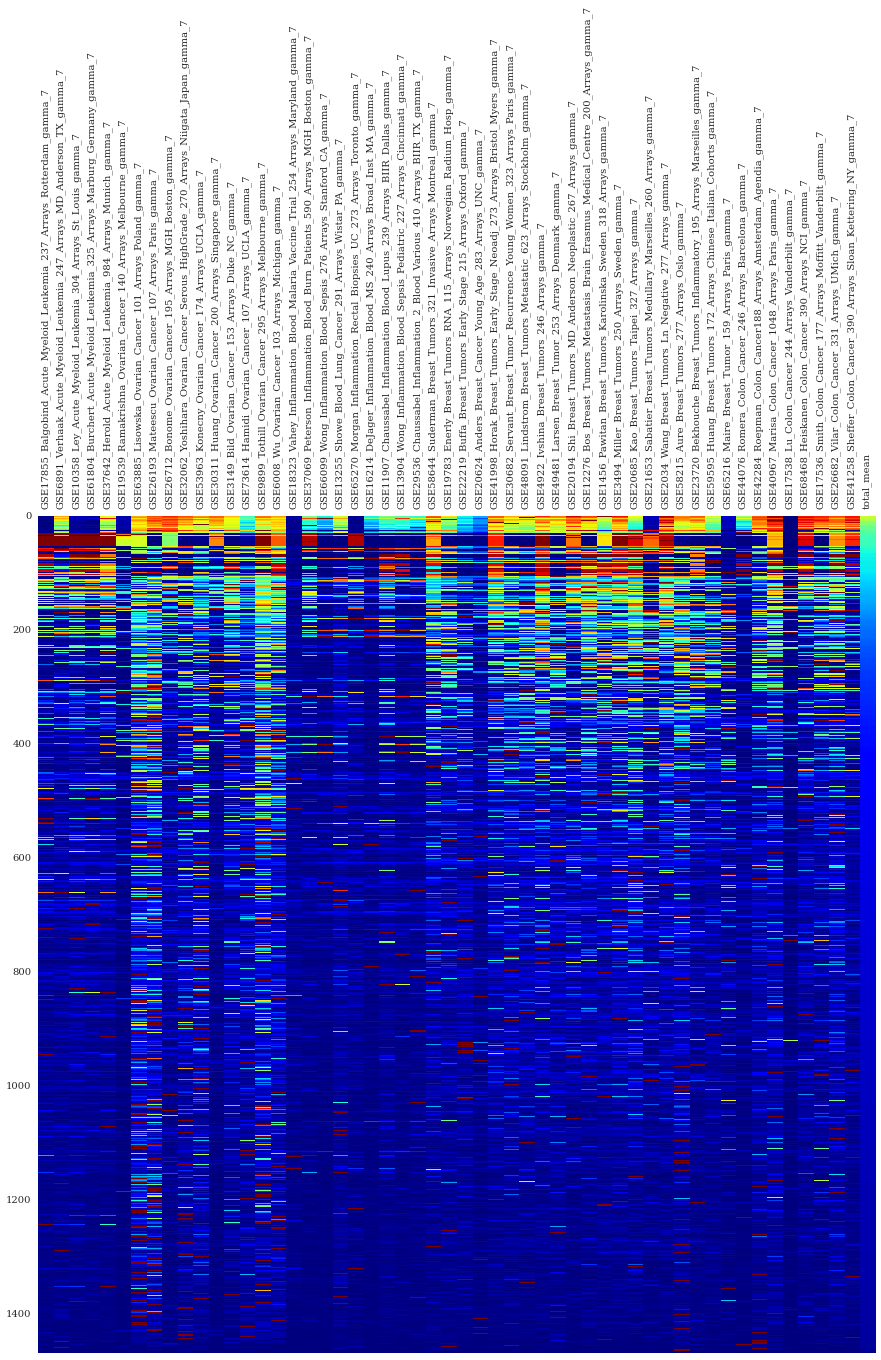

In [6]:
# plot the heatmap
plt.figure(figsize=(15,15))
plt.matshow(cluster_focal_df,fignum=False,cmap='jet',vmin=0,vmax=1,aspect='auto')
#plt.yticks(range(len(cluster_focal_df)),list(cluster_focal_df.index),fontsize=8)
plt.xticks(range(len(cluster_focal_df.columns)),list(cluster_focal_df.columns),rotation=90,fontsize=10)
plt.grid('off')

[TOC](#toc)



<a id='parse_rlabels'></a>


## Parse the row labels
__________

- Here we include two functions that will be useful for parsing row labels from DF indices, and mapping these labels to colors
- **NOTE** These functions are specific to the example dataset used here

In [78]:

def build_row_colors(nodes_df,cmap = matplotlib.cm.nipy_spectral,find_col_colors = True):
    '''
    Simple helper function for plotting to return row_colors and col_colors for sns.clustermap.
    - disease names will be extracted from df indices and columns and used for plotting
    - cmap defines the desired colormap (can be any matplotlib colormap)
    
    '''

    # make the list of disease naes
    nodes_index = list(nodes_df.index)

    dname_list = []
    for idx_temp in nodes_index:

        idx_ = idx_temp.find('_')

        dname_temp = idx_temp[:idx_]
        dname_list.append(dname_temp)

    dname_list = pd.Series(dname_list)

    # make the row colors (one color per disease)
    num_diseases = len(np.unique(dname_list))
    dnames = list(np.unique(dname_list))  #list(dname_list.unique())

    cmap_idx_dict = dict(zip(dnames,[int(round(i/float(num_diseases)*220.)+25) for i in range(num_diseases)]))

    rcolors=[]
    for dfocal in dname_list:
        #color_list = [sns.color_palette('Set2',num_diseases)[cmap_idx]]*(num_dfocal)
        color_temp = cmap(cmap_idx_dict[dfocal])
        rcolors.append(color_temp)
        
        
        
    # now find the column colors
    if find_col_colors:
        dnames_split = [split_dname(d) for d in dnames]
        
        # loop over columns to find which disease it is
        colnames = list(nodes_df.columns)
        dname_col_list = [0]*len(colnames)
        for i in range(len(colnames)):
            col = colnames[i]
            for d in dnames_split:
                # is disease d in column col?
                idx_match = col.find(d[0:5])
                if idx_match>-1:
                    dname_col_list[i]=d
                
            if type(dname_col_list[i]) != str:
                dname_col_list[i]='unknown'
                    
        
        cmap_col_idx_dict = dict(zip(dnames_split,[int(round(i/float(num_diseases)*256.)) for i in range(num_diseases)]))
        cmap_col_idx_dict['unknown'] = 255
        print(cmap_col_idx_dict)
        
        ccolors=[]
        for dfocal in dname_col_list:
            #color_list = [sns.color_palette('Set2',num_diseases)[cmap_idx]]*(num_dfocal)
            color_temp = cmap(cmap_col_idx_dict[dfocal])
            ccolors.append(color_temp)
            
        return rcolors,ccolors,dname_col_list,dname_list
        
    else:
        return rcolors,dname_col_list,dname_list


    
def split_dname(dtemp):
    '''
    Helper function to split disease name into words separated by underscores
    '''
    dkeep=dtemp
    
    icount = 0 # don't look at the first letter
    for i in range(1,len(dtemp)):
        icount+=1
        c = dtemp[i]
        if c.isupper():
            dkeep = dkeep[0:icount]+'_'+dkeep[icount:]
            icount+=1 # add another to icount to account for new underscore

    return dkeep

def get_reduced_labels(nodes_df,num_common_bigrams=25):
    '''
    Reduce the cluster labels to common bigrams
    
    '''

    cluster_labels = list(nodes_df.index)
    # shuffle cluster_labels to get rid of local structure
    np.random.shuffle(cluster_labels)
    # build up a list of the most common words
    word_list = []
    for c in cluster_labels:

        # split cluster_label into parts separated by underscore
        cluster_label = c.split('_')
        GO_temp = cluster_label[2]  # the third element is the GO term
        tokens = word_tokenize(GO_temp)
        word_list.extend(tokens)

    word_list = pd.Series(word_list)
    word_list.value_counts()


    filtered_words = [word for word in word_list if word not in stopwords.words('english')]

    # find common bigrams
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    trigram_measures = nltk.collocations.TrigramAssocMeasures()

    finder = nltk.collocations.BigramCollocationFinder.from_words(filtered_words)

    top_N = finder.nbest(bigram_measures.raw_freq,num_common_bigrams)

    # loop over cluster_labels, and replace with common phrase if it occurs
    cluster_labels = list(nodes_df.index)
    reduced_labels = []
    for c in cluster_labels:
        # split cluster_label into parts separated by underscore
        cluster_label = c.split('_')
        if cluster_label[2]=='':
            GO_temp = cluster_label[3] # the fourth element is the GO term if third is blank
        else:
            GO_temp = cluster_label[2] # the third element is the GO term

        tokens = word_tokenize(GO_temp)

        is_match = False
        i = -1
        while (not is_match) and (i<len(top_N)-1):
            i+=1
            num_overlap = len(set.intersection(set(top_N[i]),set(tokens)))
            if num_overlap>=2:  # for bigrams only
                is_match=True
                reduced_labels.append(top_N[i][0]+' ' + top_N[i][1])

        if not is_match:
            # if there isn't any match, just take the normal label
            reduced_labels.append(GO_temp)
            
    return reduced_labels
        

In [10]:
# parse first label set (called GO terms from now on)

reduced_labels = get_reduced_labels(cluster_focal_df,num_common_bigrams=0)
reduced_label_VC = pd.Series(reduced_labels).value_counts()

n_bigrams = len(np.unique(reduced_labels))-1 # include all labels

# make dictionaries going from label to index and back
label_to_idx = dict(zip(list(reduced_label_VC.index),range(len(reduced_label_VC))))
idx_to_label = dict(zip(range(len(reduced_label_VC)),list(reduced_label_VC.index)))
reduced_idx = [float(label_to_idx[label]) if label_to_idx[label]<n_bigrams else n_bigrams+1. for label in reduced_labels ]

labels = idx_to_label.values()
keys = idx_to_label.keys()

idx_to_label_reduced = dict(zip(keys[0:n_bigrams+1],labels[0:n_bigrams+1]))
idx_to_label_reduced[n_bigrams+1]='other' # set all unlabeled points to 'other'

label_to_idx_reduced = dict(zip(labels[0:n_bigrams+1],keys[0:n_bigrams+1]))
label_to_idx_reduced['other']=n_bigrams+1 # set all unlabeled points to 'other'


In [79]:
# parse second label set (called Disease names from now on)

# map diseases to colors
rcolors,tmp1,tmp2,dname_list = build_row_colors(cluster_focal_df,cmap = matplotlib.cm.nipy_spectral,find_col_colors = True)
dname_to_rcolors = dict(zip(dname_list.values,rcolors))


{'Ovarian_Cancer': 205, 'unknown': 255, 'Colon_Adenocarcinoma': 102, 'Inflammation_Blood': 154, 'Breast_Cancer': 51, 'Acute_Myeloid_Leukemia': 0}


[TOC](#toc)



<a id='dim_reduce'></a>
## Reduce to two dimensions
_______

**Methods** (scikit-learn implementations used here):
- t-SNE:  Van der Maaten, Laurens, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.2579-2605 (2008): 85.

<img src="screenshots/sklearn_tsne.png" width="600" height="600">

- Principal Component Analysis (PCA): M. Tipping and C. Bishop, Probabilistic Principal Component Analysis, Journal of the Royal Statistical Society, Series B, 61, Part 3, pp. 611-622
<img src="screenshots/sklearn_pca.png" width="600" height="600">

- Isomap: Tenenbaum, J.B.; De Silva, V.; & Langford, J.C. A global geometric framework for nonlinear dimensionality reduction. Science 290 (5500)
<img src="screenshots/sklearn_isomap.png" width="600" height="600">



In [59]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.manifold import Isomap

# select which dimensionality reduction technique you want here
dim_reduct_method = 'TSNE'

tsne = TSNE(n_components=2)
pca = PCA(n_components=2)
isomap = Isomap(n_neighbors=10,n_components=2,path_method='auto')

# drop total_mean column
focal_df = cluster_focal_df.drop('total_mean',1)
focal_df = focal_df.replace(to_replace=1.0,value=0.0)

# make an array out of the df for input into dim reduction methods
cluster_mat =np.array(focal_df)

if dim_reduct_method=='TSNE':
    cluster_transf = tsne.fit_transform(cluster_mat)
elif dim_reduct_method=='PCA':
    cluster_transf = pca.fit_transform(cluster_mat)
elif dim_reduct_method=='Isomap':
    cluster_transf = isomap.fit_transform(cluster_mat)


[TOC](#toc)



<a id='plot_transformed'></a>
## Plot the data in transformed coordinates
________

- Left panel: transformed coordinates color-coded by GO term.  Looks like there is some grouping happening, where some points labeled by the same GO term appear to be clustered together.
- Right panel:  transformed coordinates color-coded by disease name.  Again there is some clear grouping happening, easily identified by eye.

Can we quantify our observations by developing a scoring method to evaluate how localized points are by GO term and by disease name?

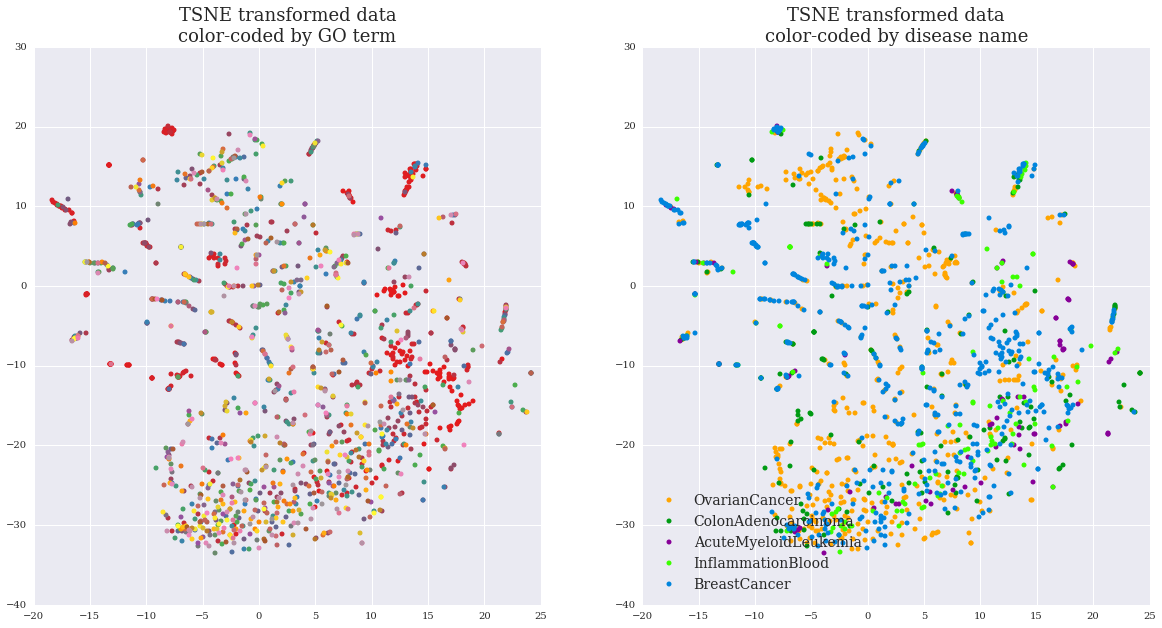

In [81]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(cluster_transf[:,0],cluster_transf[:,1],'o',color='gray',markersize=4)
for i in range(len(idx_to_label_reduced)):
    
    reduced_labels = pd.Series(reduced_labels)
    label_temp = idx_to_label_reduced[i]
    idx_focal = list(reduced_labels[reduced_labels==label_temp].index)
    if len(idx_focal)>0:
        col_temp =matplotlib.cm.Set1(int(round(float(i)/len(idx_to_label_reduced)*255)))

        plt.plot(cluster_transf[idx_focal,0],cluster_transf[idx_focal,1],'o',color=col_temp,label=idx_to_label_reduced[i],
                markersize=5)
#plt.legend(loc='upper left',fontsize=10,ncol=1)
#plt.xlim([-30,30])
plt.title(dim_reduct_method+' transformed data \ncolor-coded by GO term',fontsize=18)

plt.subplot(1,2,2)
for d in dname_to_rcolors.keys():
    
    idx_focal = list(dname_list[dname_list==d].index)
    if len(idx_focal)>0:
        col_temp =dname_to_rcolors[d]

        plt.plot(cluster_transf[idx_focal,0],cluster_transf[idx_focal,1],'o',color=col_temp,label=d,
                markersize=5)
plt.legend(fontsize=14,loc='lower left')
plt.title(dim_reduct_method+' transformed data \ncolor-coded by disease name',fontsize=18)
#plt.xlim([-30,30])



[TOC](#toc)



<a id='scoring_method'></a>
## Scoring method (Specificity)
________

- Our scoring method measures a weighted distance ($S$) between all pairs of points in the dataset, wehre the weights are determined by the labels.  If two nearby points have the same label, they will be rewarded, if they have different labels, they will be penalized.

    $ s_i = \sum_{j=1}^N \frac{1}{N}F(d_{ij}) \delta(c_{ij}) $

- Distances ($d_{ij}$ are Euclidean distances meausured in 2-d reduced space.
- $\delta(c_{ij})$ is 0 if points $i$ and $j$ have different labels, and 1 if they have the same labels.
- The distance transformation function $F(d_{ij})$ is selected by the user based on desired encoding of distance.  This transformation is necessary because we want to reward nearby points in our weighted average. Choices are:
    - 'log_inv': $F(x) = \log(1/x)$
    - 'inv': $F(x) = 1/x$
    - 'sub': $F(x) = 1-x/\max(x)$
    - 'rank': $F(x) = (1-rank(x))/N$
    - 'rank_inv': $F(x) = 1/rank(x)$

In [20]:
def weighted_score(x,y,labels1,labels2,dtype='log_inv'):
    '''
    This function calculates the weighted scores of points in x,y, defined by labels1 and labels2.
    - Points are scored more highly if they are close to other points with the same label, and are penalized if 
    they are close to points with different labels.  
    
    '''

    d = squareform(pdist(np.transpose([x,y])))
    #d = squareform(pdist(cluster_mat))
    
    if dtype=='log_inv':
        d_log_inv = np.log(1/d)
        np.fill_diagonal(d_log_inv,0)
        d_transf = d_log_inv
    elif dtype=='inv':
        d_inv = 1/d
        np.fill_diagonal(d_inv,0)
        d_transf = d_inv
    elif dtype=='sub':
        d_sub = 1 - d/np.max(d)
        np.fill_diagonal(d_sub,1)
        d_transf = d_sub
        
    elif dtype=='rank':
        d_rank = []
        for i in range(len(d)):
            d_rank.append(len(d)-np.argsort(d[i,:]))
        
        d_transf = d_rank
    elif dtype=='rank_inv':
        d_inv_rank = []
        for i in range(len(d)):
            d_inv_rank.append(1./(np.argsort(d[i,:])+1))
        
        d_transf = d_inv_rank


    
    labels1 = pd.Series(labels1)
    label_delta_mat = np.zeros((len(labels1),len(labels1)))
    for i in range(len(labels1)):
        label_temp = labels1==labels1[i]
        label_plus_minus = [(int(label)-.5)*2 for label in label_temp]

        label_delta_mat[i,:] = label_plus_minus


    score1 = np.mean(d_transf*label_delta_mat,axis=0)


    labels2 = pd.Series(labels2)
    label_delta_mat = np.zeros((len(labels2),len(labels2)))
    for i in range(len(labels2)):
        label_temp = labels2==labels2[i]
        label_plus_minus = [(int(label)-.5)*2 for label in label_temp]

        label_delta_mat[i,:] = label_plus_minus


    score2 = np.mean(d_transf*label_delta_mat,axis=0)
    
    return score1,score2
    
    

In [82]:
# calculate the score here
x = cluster_transf[:,0]
y = cluster_transf[:,1]
labels1 = [l if l in label_to_idx_reduced.keys() else 'other' for l in reduced_labels]
labels2 = dname_list

score1,score2 = weighted_score(x,y,labels1,labels2,dtype='log_inv')

# make a dataframe to store the score results
Score_df = pd.DataFrame({'score1':list(score1),'score2':list(score2),
                         'GOlabels':list(labels1),'Dnames':list(dname_list)},index=range(len(score1)))

# calculate the average score for each GOterm and disease name
sGO_GB_mean = []
sD_GB_mean = []
sGO_GB_mean = Score_df.groupby('GOlabels').mean()
sD_GB_mean = Score_df.groupby('Dnames').mean()


# measure how many disease names are associated with each GOterm
GO_GB_D = Score_df['Dnames'].groupby(Score_df['GOlabels']).value_counts()



# need to normalize by total number of clusters in each disease
clusters_per_disease = Score_df['Dnames'].value_counts()
clusters_per_GOterm = Score_df['GOlabels'].value_counts()


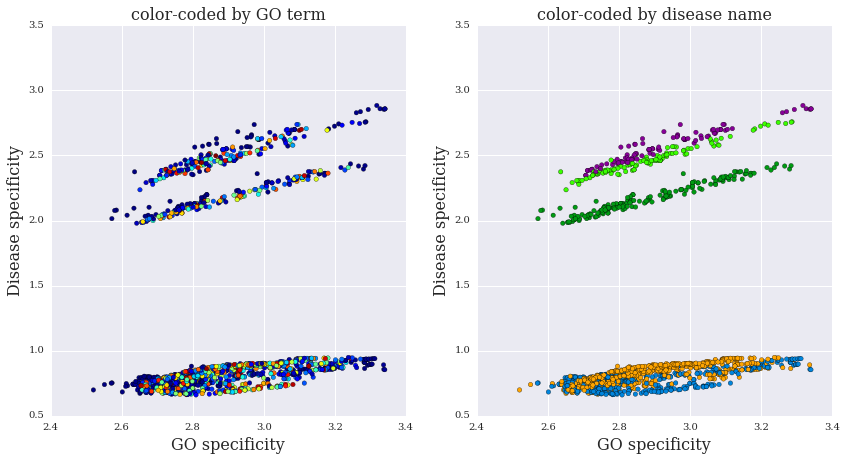

In [83]:
# plot the reduced data in specificity coordinates here
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.scatter(score1,score2,c=[label_to_idx_reduced[l] for l in labels1],cmap='jet')
plt.xlabel('GO specificity',fontsize=16)
plt.ylabel('Disease specificity',fontsize=16)
plt.title('color-coded by GO term',fontsize=16)


plt.subplot(1,2,2)
plt.scatter(score1,score2,c=[dname_to_rcolors[d] for d in dname_list],cmap='jet')
plt.xlabel('GO specificity',fontsize=16)
plt.ylabel('Disease specificity',fontsize=16)
plt.title('color-coded by disease name',fontsize=16)


[TOC](#toc)



<a id='plot_specificity'></a>
## Plot the average specificities per GO term and per disease name
________

- Plot points as label names


- Left panel: GO term plotted in specificity coordinates.  Points are color-coded by the disease which contains the most counts of that term.  Points are larger if the GO term has more occurrences in the data.  
    - GO terms with high GO specificity **and** Disease specificity (upper right quadrant) are likely to be found nearby to other points with the same GO label and disease label.  
    - GO terms with high GO specificity but low disease specificity are likely to be found near points with the same GO labels, but different disease labels
    - GO terms with low GO specificity, but high disease specificity are likely to be found near points with different GO labels, but the same disease labels.
    - Go terms with low specificity in both GO and Disease (lower left quadrant) are not likely to be found near other points with the same labels.  
    
- Right panel: Disease names plotted in specificity coordinates.  
    - Diseases with high specificity in both GO and Disease are likely to be found near points with the same GO labels and Disease labels.
    - Diseases with high GO specificity but low disease specificity are found near points with the same GO labels, but different disease labels.
    - Diseases with low GO specificity but high disease specificity are found near points with different GO labels, but the same disease labels.
    - Diseases with low specificity in both GO and disease are not likely to be found near other points with the same labels.

(2.5, 3.5)

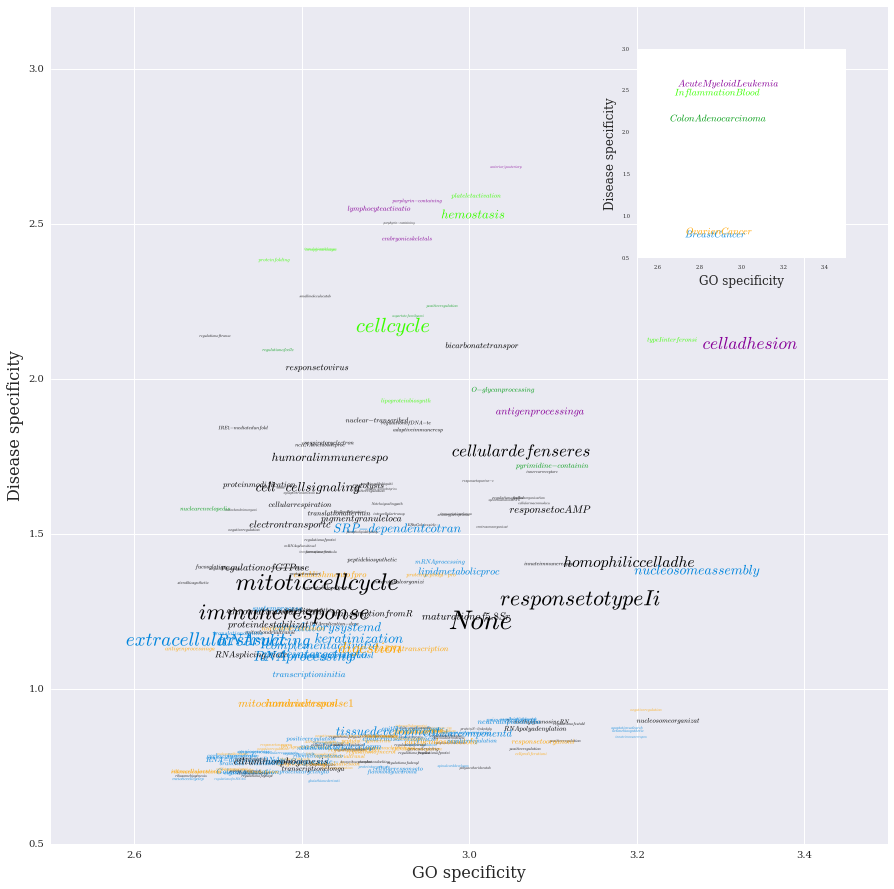

In [92]:
fig = plt.figure(figsize=(15,15))
axes = fig.add_subplot(1,1,1)
subpos = [0.7,0.7,0.25,0.25]
for GOname in list(sGO_GB_mean.index):
    msize = np.log(clusters_per_GOterm[GOname])*3*15 # set the marker size
    
    # get the text color
    D_freq_norm = GO_GB_D[GOname]# /clusters_per_disease # normalize by number of clusters per disease
    D_freq_norm.sort(ascending=False)

    if (D_freq_norm[0]/float(np.sum(D_freq_norm))) > .5:
        most_frequent_D = D_freq_norm.index[0] # get the most frequent disease for focal GO term
        color_temp = dname_to_rcolors[most_frequent_D]
    else:
        # if focal GOname doesn't really belong to any disease, make it white
        color_temp='black'
    axes.plot(sGO_GB_mean['score1'][GOname],sGO_GB_mean['score2'][GOname],
             '.',marker=r'$'+GOname[0:20]+'$',markersize=msize,color=color_temp)
    
plt.xlabel('GO specificity',fontsize=16)
plt.ylabel('Disease specificity',fontsize=16)
plt.xlim([2.5,3.5])
plt.ylim([0.5,3.2])
    
subax1 = add_subplot_axes(axes,subpos)

for Dname in list(sD_GB_mean.index):
    msize = len(Dname)*5
    subax1.plot(sD_GB_mean['score1'][Dname],sD_GB_mean['score2'][Dname],
             '.',marker=r'$'+Dname+'$',markersize=msize,color=dname_to_rcolors[Dname])
    
plt.xlabel('GO specificity',fontsize=12)
plt.ylabel('Disease specificity',fontsize=12)
plt.xlim([2.5,3.5])



In [32]:
def add_subplot_axes(ax,rect,axisbg='w'):
    '''
    This function allows for plotting of inset subplots (from http://stackoverflow.com/questions/17458580/embedding-small-plots-inside-subplots-in-matplotlib)
    '''
    
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

[TOC](#toc)
